In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand

spark = SparkSession.builder.appName("dataSet").getOrCreate()
file = "heart_2020_cleaned.csv"
df = spark.read.csv(file, header=True, inferSchema=True)

columns_to_drop = ["Race", "MentalHealth", "PhysicalHealth"]
df = df.drop(*columns_to_drop)

from pyspark.sql.functions import stddev, mean, abs, col
bmi_stats = df.select(mean(col("BMI")).alias("mean_BMI"), stddev(col("BMI")).alias("stddev_BMI")).first()
mean_bmi = bmi_stats["mean_BMI"]
stddev_bmi = bmi_stats["stddev_BMI"]
sleep_time_stats = df.select(mean(col("SleepTime")).alias("mean_SleepTime"), stddev(col("SleepTime")).alias("stddev_SleepTime")).first()
mean_sleep_time = sleep_time_stats["mean_SleepTime"]
stddev_sleep_time = sleep_time_stats["stddev_SleepTime"]
threshold = 3
df = df.withColumn("z_score_BMI", abs((col("BMI") - mean_bmi) / stddev_bmi))
df = df.withColumn("z_score_SleepTime", abs((col("SleepTime") - mean_sleep_time) / stddev_sleep_time))
df = df.filter(col("z_score_BMI") <= threshold)
df = df.filter(col("z_score_SleepTime") <= threshold)
df = df.drop("z_score_BMI", "z_score_SleepTime")

df = df.dropna()

from pyspark.sql import functions as F

df = df.withColumn(
    'BMI_Category',
    F.when((df['BMI'] < 18.5), 'Low')
    .when((df['BMI'] >= 18.5) & (df['BMI'] < 24.9), 'Normal')
    .when((df['BMI'] >= 25.0) & (df['BMI'] < 29.9), 'Over')
    .when((df['BMI'] >= 30.0) & (df['BMI'] < 34.9), 'ObeseI')
    .when((df['BMI'] >= 35.0) & (df['BMI'] < 39.9), 'ObesityII')
    .otherwise('ObesityIII')
)
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

binary_features = ["HeartDisease", "AlcoholDrinking", "Stroke", "DiffWalking", "Smoking", "Diabetic", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

for column in binary_features:
    df = df.withColumn(column, F.when(df[column] == 'Yes', 1).otherwise(0))

df = df.withColumn("Sex", F.when(df["Sex"] == "Male", 1).otherwise(0))

df = df.withColumn("Diabetic", F.when(df["Diabetic"] == "No, borderline diabetes", 0).when(df["Diabetic"] == "Yes (during pregnancy)", 1).otherwise(df["Diabetic"]))


string_indexer = StringIndexer(inputCol="BMI_Category", outputCol="BMI_Category_Index")
model = string_indexer.fit(df)
df = model.transform(df)

string_indexer = StringIndexer(inputCol="AgeCategory", outputCol="AgeCategory_Index")
model = string_indexer.fit(df)
df = model.transform(df)

string_indexer = StringIndexer(inputCol="GenHealth", outputCol="GenHealth_Index")
model = string_indexer.fit(df)
df = model.transform(df)

columns_to_drop = ["BMI_Category", "AgeCategory", "GenHealth"]
df = df.drop(*columns_to_drop)

df_high = df.filter(df["HeartDisease"] == 0)
df_low = df.filter(df["HeartDisease"] == 1)

num_samples = df_low.count()

df_high_sampled = df_high.sample(False, num_samples / df_high.count(), seed=42)

df = df_high_sampled.union(df_low)

from pyspark.ml.feature import VectorAssembler

feature_columns = ["BMI", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", 
                   "Sex", "Diabetic", "PhysicalActivity", "SleepTime", "Asthma", 
                   "KidneyDisease", "SkinCancer", "BMI_Category_Index", 
                   "AgeCategory_Index", "GenHealth_Index"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

output = assembler.transform(df)

final_data = output.select("features", "HeartDisease")

train_data, test_data = final_data.randomSplit([0.7, 0.3])


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/09 14:11:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# SVM Model
svm = LinearSVC(labelCol="HeartDisease", featuresCol="features")

model = svm.fit(train_data)

predictions = model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease")
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

Accuracy: 0.786228456008504


In [3]:
param_map = model.extractParamMap()
print(param_map)

{Param(parent='LinearSVC_75cd11acc0c1', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearSVC_75cd11acc0c1', name='featuresCol', doc='features column name.'): 'features', Param(parent='LinearSVC_75cd11acc0c1', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LinearSVC_75cd11acc0c1', name='labelCol', doc='label column name.'): 'HeartDisease', Param(parent='LinearSVC_75cd11acc0c1', name='maxBlockSizeInMB', doc='maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0.'): 0.0, Param(parent='LinearSVC_75cd11acc0c1', name='maxIter', doc='max number of iterations (>= 0).'): 100, Param(parent='LinearSVC_75cd11acc0c1', name='predictionCol', doc='prediction column name.'): 'prediction', Param(parent='Line

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LinearSVCModel

predictions = model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", metricName="areaUnderROC")

auc = evaluator.evaluate(predictions)
print("AUC: " + str(auc))

coefficients = model.coefficients
intercept = model.intercept

print("Coefficients: " + str(coefficients))
print("Intercept: " + str(intercept))

AUC: 0.785707460254017
Coefficients: [0.0005024231446182544,0.43835591151950937,-0.2917911218620303,1.2810161027161429,0.8451437288395424,0.4717877326513343,0.9020053794941963,-0.18176236316372135,0.021961335352705887,0.158448084936633,0.7469622454757158,0.8805131290242593,-0.010739224190918247,-0.0873522090613425,0.16877967927548254]
Intercept: -0.9952754709165723


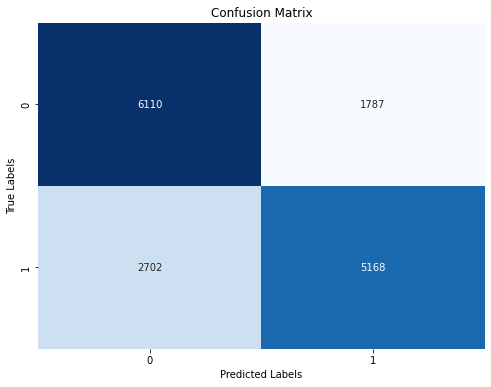

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = np.array(test_data.select("HeartDisease").collect())
y_pred = np.array(predictions.select("prediction").collect())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


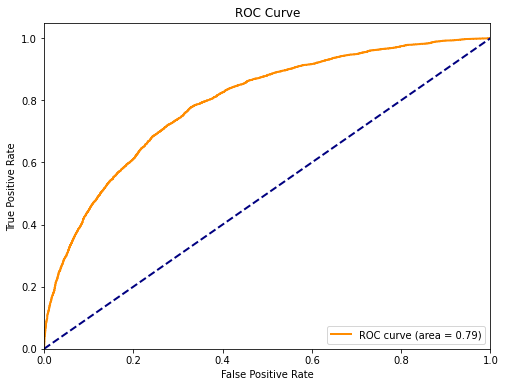

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = predictions.select("HeartDisease").rdd.flatMap(lambda x: x).collect()
y_raw = predictions.select("rawPrediction").rdd.flatMap(lambda x: x).collect()

y_prob = [raw[1] for raw in y_raw]

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 创建一个BinaryClassificationEvaluator对象
evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", rawPredictionCol="prediction", metricName="areaUnderROC")

# 使用评估器来计算AUC
auc = evaluator.evaluate(predictions)

# 打印出AUC值
print("Accuracy: {:.5f}".format(auc))

Accuracy: 0.72


23/10/09 14:31:26 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


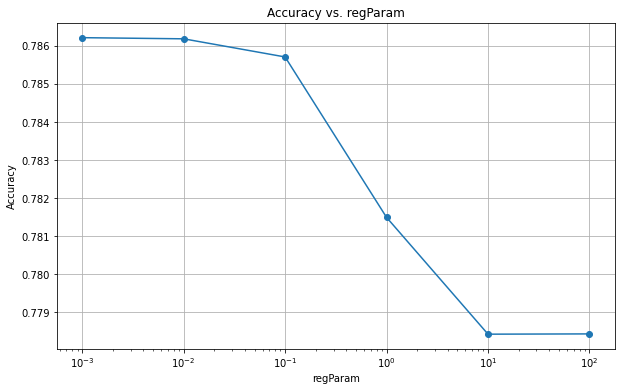

[0.7862202900091785, 0.7861900933216134, 0.7857133294896361, 0.781497445299743, 0.7784280403543629, 0.7784352433069845]


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

reg_params = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

accuracies = []

for reg_param in reg_params:
    svm = LinearSVC(labelCol="HeartDisease", featuresCol="features", regParam=reg_param)

    model = svm.fit(train_data)

    predictions = model.transform(test_data)

    evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease")
    accuracy = evaluator.evaluate(predictions)
    
    accuracies.append(accuracy)


plt.figure(figsize=(10, 6))
plt.plot(reg_params, accuracies, marker='o', linestyle='-')
plt.xlabel('regParam')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. regParam')
plt.xscale('log')  
plt.grid(True)
plt.show()
print(accuracies)